In [36]:
import pandas as pd
import os
import sklearn
import numpy as np
from scipy.interpolate import *
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as k
import seaborn as sns
pd.set_option('display.max_rows', None)


In [2]:
os.getcwd()

'C:\\Users\\User\\Documents\\GitHub\\Hypertension_prediction\\Hypertension(regularly sampled data)\\Codebase(previous paper codes)\\Hypertension_code_amy'

In [3]:
#df = pd.read_excel (r'Mappings.xlsx')
p9690 =pd.read_csv (r'./Output/missing_value_imputed/p9690_missing.csv')
p9630 =pd.read_csv (r'./Output/missing_value_imputed/p9630_missing.csv')
p9888 =pd.read_csv (r'./Output/missing_value_imputed/p9888_missing.csv')
p10049=pd.read_csv (r'./Output/missing_value_imputed/p10049_missing.csv')
p10412=pd.read_csv (r'./Output/missing_value_imputed/p10412_missing.csv')

In [4]:
#!git clone https://github.com/caow13/BRITS.git

In [5]:
#from sklearn.impute import KNNImputer
#p10049_knn_imputed = p10049.copy(deep=True)
#knn_imp = KNNImputer(n_neighbors=3)
#p10049_knn_imputed.loc[:, :] = knn_imp.fit_transform(p10049_knn_imputed)


ValueError: could not convert string to float: '2018-05-17 10:00:00'

In [53]:
#from sklearn.datasets import make_friedman2
#from sklearn.gaussian_process import GaussianProcessRegressor
#from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
#X, y = make_friedman2(n_samples=500, noise=0, random_state=0)
#kernel = DotProduct() + WhiteKernel()
#gpr = GaussianProcessRegressor(kernel=kernel,
#        random_state=0).fit(X, y)
#gpr.score(X, y)

#gpr.predict(X[:2,:], return_std=True)


C:\Users\User\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(array([653.08792288, 592.16905327]), array([316.68016218, 316.65121679]))

first create patient train test set

In [6]:
p10049['Timestamp'] = pd.to_datetime(p10049['Timestamp'])
p10049['DOB'] = pd.to_datetime(p10049['DOB'])
p10049.set_index('Timestamp', inplace=True)

In [7]:
p10049.dtypes

UserID               float64
Systolic             float64
Diastolic            float64
Heart Rate           float64
DOB           datetime64[ns]
Weight               float64
Height               float64
Gender                object
dtype: object

In [8]:
p10049_s= p10049['Systolic']
p10049_d= p10049['Diastolic']
p10049_hr= p10049['Heart Rate']
p10049_all= p10049[['Systolic','Diastolic','Heart Rate']]
p10049_s_train,p10049_s_test= np.split(p10049_s, [int(.7 *len(p9690))])
p10049_d_train,p10049_d_test= np.split(p10049_d, [int(.7 *len(p9690))])
p10049_hr_train,p10049_hr_test= np.split(p10049_hr, [int(.7 *len(p9690))])
p10049_all_train,p10049_all_test= np.split(p10049_all, [int(.7 *len(p9690))])



interpolation

In [9]:
df_poly_imputed = p10049_all.interpolate(method='polynomial', order=2)
df_time_imputed = p10049_all.interpolate(method='time')
df_spline_imputed = p10049_all.interpolate(method='spline', order=2)
df_barycentric_imputed = p10049_all.interpolate(method='barycentric', order=2)


C:\Users\User\anaconda3\envs\Hypertension_env\lib\site-packages\scipy\interpolate\polyint.py:539: RuntimeWarning: overflow encountered in multiply
  self.wi[:j] *= (self.xi[j]-self.xi[:j])
C:\Users\User\anaconda3\envs\Hypertension_env\lib\site-packages\scipy\interpolate\polyint.py:540: RuntimeWarning: overflow encountered in reduce
  self.wi[j] = np.multiply.reduce(self.xi[:j]-self.xi[j])
C:\Users\User\anaconda3\envs\Hypertension_env\lib\site-packages\scipy\interpolate\polyint.py:637: RuntimeWarning: invalid value encountered in true_divide
  p = np.dot(c,self.yi)/np.sum(c,axis=-1)[...,np.newaxis]


KNN Inputation

In [12]:
# Imputing with KNNImputer

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

#Define a subset of the dataset
df_knn = p10049_all.copy()
#p9690.filter(['Systolic','Diastolic','Heart Rate'], axis=1).copy()


# Define scaler to set values between 0 and 1

scaler = MinMaxScaler(feature_range=(0, 1))
df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)

# Define KNN imputer and fill missing values
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)


Multivariate Imputation by Chained Equations (MICE)

In [13]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

df_mice = p10049_all.copy()

# Define MICE Imputer and fill missing values
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)

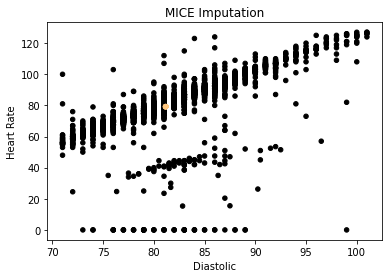

In [59]:
fig = plt.Figure()
null_values = p10049_all['Systolic'].isnull() 
fig = df_mice_imputed.plot(x='Diastolic', y='Heart Rate', kind='scatter', c=null_values, cmap='copper', title='MICE Imputation', colorbar=False)
#https://towardsdatascience.com/imputing-missing-data-with-simple-and-advanced-techniques-f5c7b157fb87#:~:text=Time%20Series%20Imputation&text=One%20way%20to%20impute%20missing,with%20the%20previously%20observed%20value

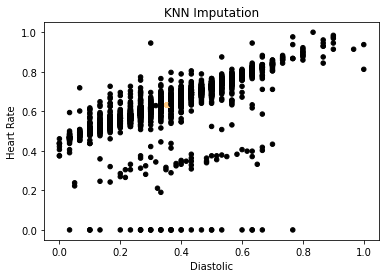

In [31]:
fig = plt.Figure()
null_values = p9690_all['Systolic'].isnull() 
fig = df_knn_imputed.plot(x='Diastolic', y='Heart Rate', kind='scatter', c=null_values, cmap='copper', title='KNN Imputation', colorbar=False)


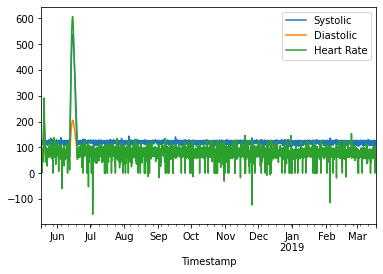

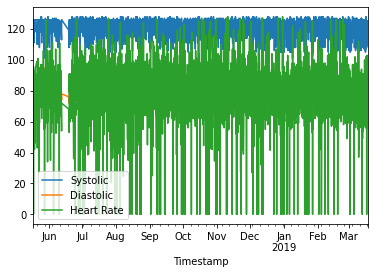

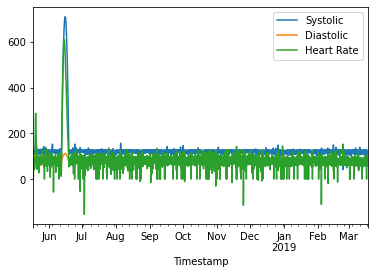

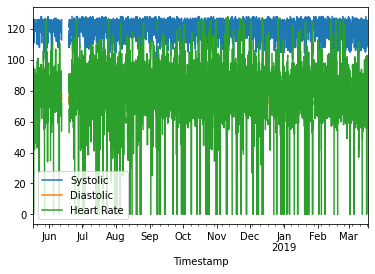

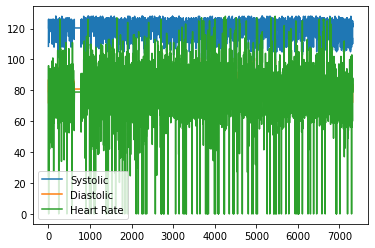

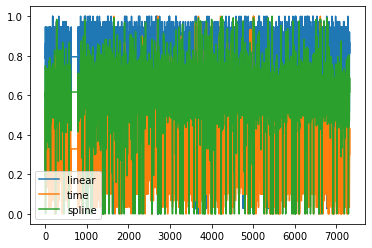

In [22]:
figsize=(40,15)
df_poly_imputed.plot()
df_time_imputed.plot()
df_spline_imputed.plot()
df_barycentric_imputed.plot()
df_mice_imputed.plot()
df_knn_imputed.plot()
#lines, labels = plt.gca().get_legend_handles_labels()
#labels = ['linear', 'time' ,'spline','barycentric']
plt.legend(lines, labels, loc='best')

In [113]:
#!pip3 install jinja2==3.0.1


In [44]:
from pycaret.anomaly import *
s = setup(df_mice_imputed, use_gpu=True)


,Description,Value
0,session_id,4527
1,Original Data,"(7322, 3)"
2,Missing Values,False
3,Numeric Features,3
4,Categorical Features,0
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(7322, 3)"
9,CPU Jobs,-1


In [45]:
iforest = create_model('iforest')
print(iforest)

IForest(behaviour='new', bootstrap=False, contamination=0.05,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=-1,
    random_state=4527, verbose=0)


In [46]:
models()


,Name,Reference
ID,,
abod,Angle-base Outlier Detection,pyod.models.abod.ABOD
cluster,Clustering-Based Local Outlier,pyod.models.cblof.CBLOF
cof,Connectivity-Based Local Outlier,pyod.models.cof.COF
iforest,Isolation Forest,pyod.models.iforest.IForest
histogram,Histogram-based Outlier Detection,pyod.models.hbos.HBOS
knn,K-Nearest Neighbors Detector,pyod.models.knn.KNN
lof,Local Outlier Factor,pyod.models.lof.LOF
svm,One-class SVM detector,pyod.models.ocsvm.OCSVM
pca,Principal Component Analysis,pyod.models.pca.PCA


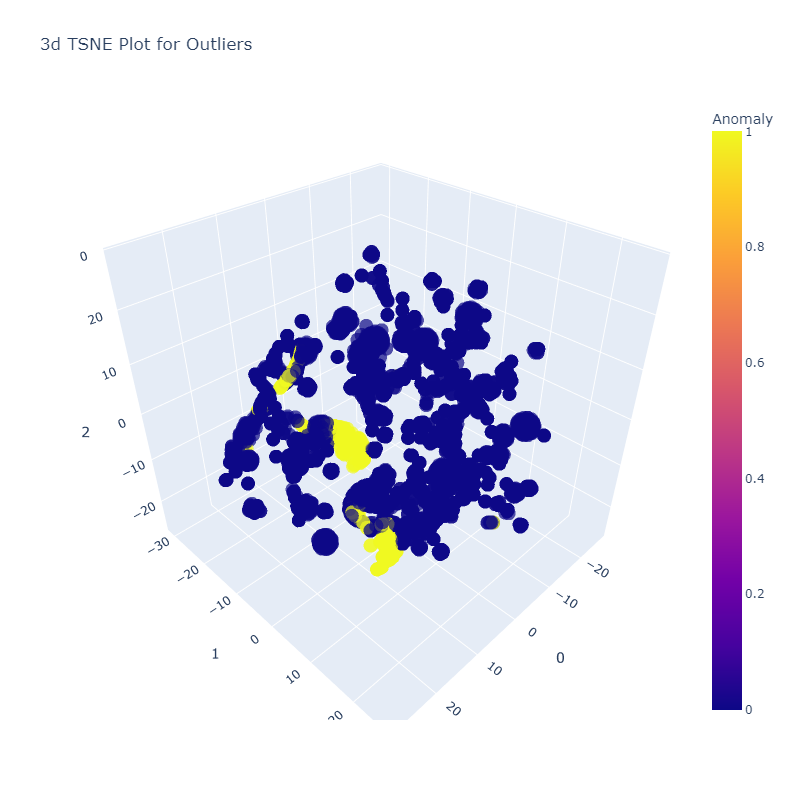

In [47]:
plot_model(iforest, plot = 'tsne')

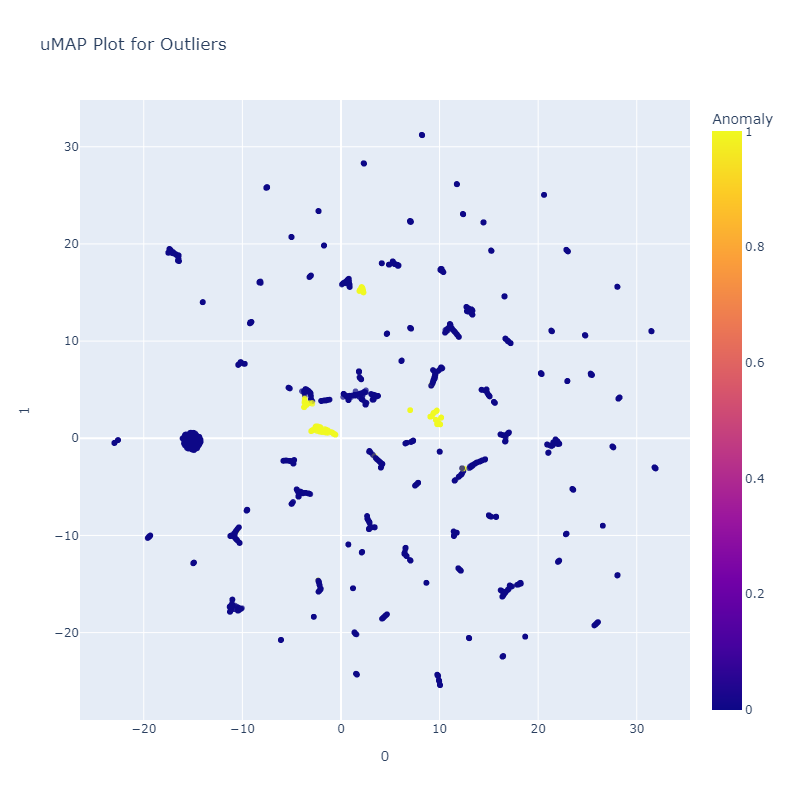

In [48]:
plot_model(iforest, plot = 'umap')

In [49]:
result = assign_model(iforest)
result

,Systolic,Diastolic,Heart Rate,Anomaly,Anomaly_Score
0,108.5,72.0,24.5,1,0.046642
1,119.0,76.0,53.0,0,-0.095779
2,123.0,81.0,82.0,0,-0.238932
3,126.0,87.0,96.0,0,-0.149701
4,121.5,80.0,40.0,0,-0.064501
...,...,...,...,...,...
7317,120.0,83.0,88.0,0,-0.211116
7318,123.0,81.0,80.0,0,-0.243104
7319,121.0,83.0,88.0,0,-0.217387
7320,122.0,84.0,88.0,0,-0.216582


In [50]:
predictions = predict_model(iforest, data = )
predictions.head()

KeyError: "None of [Index(['Systolic', 'Diastolic', 'Heart Rate'], dtype='object')] are in the [columns]"

In [ ]:
save_model(iforest, 'iforest_pipeline')
loaded_model = load_model('iforest_pipeline')
print(loaded_model)